# CPTu data interpolation and denoising using Convolutional Neural Networks

This notebook details the proposed framework and process of interpolating and reconstructing CPTu data using an *Ensembled Convolutional Autoencoder* apporach.

This project is completed by **Siu Kai Cheung** from the University of Toronto in collaboration with Professor **Weiqiang Feng** from the Southern University of Science and Technology.

Please note that the dataset used in the project is confidential and was solely used for this research project.

## Install and import libraries

In [ ]:
# Load data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
%pip install scikit-gstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 29.6 MB/s 
  Created wheel for scikit-gstat: filename=scikit_gstat-1.0.2-py3-none-any.whl size=703184 sha256=5dccbef5adfb9ad4db0a5c7b5f1932391258d1ab6d5fbf2a36e45fd8143ddd45
  Stored in directory: /root/.cache/pip/wheels/9e/b7/60/a9ca776c9090127655f30d9b7b52603fe8dbe633b576b1e1d9
Successfully built scikit-gstat


In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

from scipy.interpolate import interp1d

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch library
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

# sklearn
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

# randomization
import random

# save file
import json

# timestamp
from datetime import datetime

import math as m

## Data Wrangling and Cleaning

The CPTu data was stored in xls and A0 file format and required some cleaning

In [ ]:
# 1a) convert data to panda dataframe
datasetdir = '/content/drive/MyDrive/UofT Civil Engineering/2022 Summer/Summer Research at SUSTech/CPTU_Dataset'

dfs_CPTU = {}
widths = [7, 10, 11, 11, 11]
features = ['Reading', 'Depth (m)', 'Tip Resistance (MPa)', 'Friction (MPa)', 'Pore (MPa)']
skiprows = 27

for subdir, dirs, files in os.walk(datasetdir):
  test_label = subdir.split('/')[-1]

  # Skip CPTU dissipation test
  if 'D' in test_label:
    continue
  
  for file in files:
    filedir = os.path.join(subdir, file)

    if file.endswith('.xls'):
      df_CPTU = pd.read_excel(filedir, header=None, skiprows=2)

      # remove last 1 or 2 columns regarding Slope
      df_CPTU = df_CPTU.iloc[:,:4]
      df_CPTU.columns = features[1:]

      df_CPTU['Reading'] = [i for i in range(len(df_CPTU.index))]

      # change all to numeric + fill NaN with 0
      df_CPTU = df_CPTU.apply(pd.to_numeric).fillna(0)

      # add to dataframe dictionary
      dfs_CPTU[test_label] = df_CPTU

    if 'A0' in file:
      df_CPTU = pd.read_fwf(filedir, widths=widths, header=None)

      # remove last 1 or 2 columns regarding Slope
      df_CPTU = df_CPTU.iloc[:,0:5]
      df_CPTU.columns = features

      # remove all non-numeric data
      df_CPTU = df_CPTU[pd.to_numeric(df_CPTU['Reading'], errors='coerce').notnull()]

      # change all to numeric + fill NaN with 0
      df_CPTU = df_CPTU.apply(pd.to_numeric).fillna(0)

      # add to dataframe dictionary
      dfs_CPTU[test_label] = df_CPTU

df_CPTU

,Reading,Depth (m),Tip Resistance (MPa),Friction (MPa),Pore (MPa)
20,264,0.000,0.0000,0.0000,0.0000
21,265,0.009,0.0325,0.0000,0.0000
22,266,0.018,0.0285,0.0000,0.0015
23,267,0.027,0.0244,0.0000,0.0018
24,268,0.036,0.0285,0.0000,0.0018
...,...,...,...,...,...
4348,4592,37.421,35.7224,0.1000,0.3614
4349,4593,37.429,36.8080,0.1029,0.3635
4350,4594,37.438,37.8285,0.1046,0.3599
4351,4595,37.447,38.8856,0.1065,0.3466


In [ ]:
# 2. Handle test locations
locationsdir = '/content/drive/MyDrive/UofT Civil Engineering/2022 Summer/Summer Research at SUSTech/'
df_locations = pd.read_csv(locationsdir + "CPTU_Test_Locations.csv")
# df_locations = df_locations[df_locations['Label'].str.contains('D')==False]

condition = df_locations['Label'].str.len() == 6
df_locations['Label'][condition] = df_locations['Label'][condition].str[:4] + '0' + df_locations['Label'][condition].str[4:]

df_locations

# Note: Min penetration depth is 27m.

,Label,X,Y,Test Height,Penetration Depth,Date
0,CPTU030,352758.333,442301.898,-7.34,45.820,12/30/2010
1,CPTU031,352758.803,442352.274,-7.46,59.956,1/1/2011
2,CPTU032,352793.829,442401.421,-7.68,57.091,1/1/2011
3,CPTU033,352724.046,442402.139,-16.16,51.854,4/14/2011
4,CPTU034,352757.784,442447.210,-16.39,50.740,4/13/2011
...,...,...,...,...,...,...
398,CPTUD18,352729.275,447985.450,-9.67,38.396,3/4/2011
399,CPTUD19,352735.951,448465.126,-9.68,35.579,3/21/2011
400,CPTUD20,352668.296,448562.250,-9.78,33.126,3/27/2011
401,CPTUD21,352683.903,448624.868,-9.82,36.533,3/28/2011


## Data Exploration

Text(0, 0.5, 'Number of Tests')

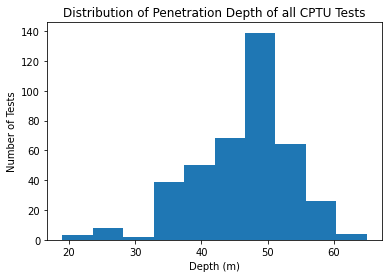

In [ ]:
# Look into Penetration Depth distribution
penetration_depths = df_locations['Penetration Depth'].astype(int).plot
penetration_depths.hist()
title = 'Distribution of Penetration Depth of all CPTU Tests'
plt.title(title)
plt.xlabel('Depth (m)')
plt.ylabel('Number of Tests')

In [ ]:
# 2a) linearly interpolate data and ensure unifrom depth interval

dfs_CPTU_standardized = {}
MAX_DEPTH = 33  # metre
DEPTH_INTERVAL = 0.01 # metre

df_locations_MIN_PENETRATION_DEPTH = df_locations[df_locations['Penetration Depth'] >= MAX_DEPTH]

labels_MAX_DEPTH = set(df_locations_MIN_PENETRATION_DEPTH['Label']) & set(dfs_CPTU.keys())

for sample in labels_MAX_DEPTH:
  df_CPTU_sample = dfs_CPTU[sample]

  x_depth = df_CPTU_sample['Depth (m)'].to_numpy()
  y_tip = df_CPTU_sample['Tip Resistance (MPa)'].to_numpy()
  y_friction = df_CPTU_sample['Friction (MPa)'].to_numpy()
  y_pore = df_CPTU_sample['Pore (MPa)'].to_numpy()

  f_tip = interp1d(x_depth, y_tip)
  f_friction = interp1d(x_depth, y_friction)
  f_pore = interp1d(x_depth, y_pore)

  x_depth_uniform = np.linspace(0, MAX_DEPTH, num=int(MAX_DEPTH/DEPTH_INTERVAL) + 1, endpoint=True)
  
  data_standardized = {
      'Depth (m)': x_depth_uniform,
      'Tip Resistance (MPa)': f_tip(x_depth_uniform),
      'Friction (MPa)': f_friction(x_depth_uniform),
      'Pore (MPa)': f_pore(x_depth_uniform),
      }

  df_CPTU_standardized = pd.DataFrame(data_standardized)
  dfs_CPTU_standardized[sample] = df_CPTU_standardized

In [ ]:
df_locations_MIN_DEPTH = df_locations[df_locations['Penetration Depth'] >= MAX_DEPTH]

ratio = len(df_locations_MIN_DEPTH) / len(df_locations)
ratio

0.967741935483871

In [ ]:
# scale data to minmax
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

df_locations_MIN_PENETRATION_DEPTH[['X', 'Y']] = min_max_scaler.fit_transform(df_locations_MIN_PENETRATION_DEPTH[['X', 'Y']])

df_locations_MIN_PENETRATION_DEPTH

,Label,X,Y,Test Height,Penetration Depth,Date
0,CPTU030,0.584923,0.000000,-7.34,45.820,12/30/2010
1,CPTU031,0.586373,0.007512,-7.46,59.956,1/1/2011
2,CPTU032,0.694430,0.014840,-7.68,57.091,1/1/2011
3,CPTU033,0.479147,0.014947,-16.16,51.854,4/14/2011
4,CPTU034,0.583230,0.021668,-16.39,50.740,4/13/2011
...,...,...,...,...,...,...
398,CPTUD18,0.495278,0.847476,-9.67,38.396,3/4/2011
399,CPTUD19,0.515874,0.919001,-9.68,35.579,3/21/2011
400,CPTUD20,0.307156,0.933483,-9.78,33.126,3/27/2011
401,CPTUD21,0.355304,0.942820,-9.82,36.533,3/28/2011


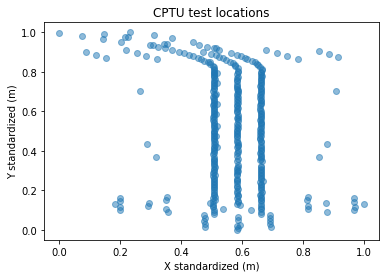

In [ ]:
# Check the locations of the test samples
xcoord = df_locations_MIN_PENETRATION_DEPTH['X'].to_numpy()
ycoord = df_locations_MIN_PENETRATION_DEPTH['Y'].to_numpy()

plt.scatter(xcoord, ycoord, alpha=0.5)
plt.title('CPTU test locations')
plt.xlabel('X standardized (m)')
plt.ylabel('Y standardized (m)')
plt.show()

In [ ]:
# Only keep the middle three lines
df_locations_cleaned = df_locations_MIN_PENETRATION_DEPTH.drop(df_locations_MIN_PENETRATION_DEPTH[df_locations_MIN_PENETRATION_DEPTH['X'] < 0.5].index)
df_locations_cleaned.drop(df_locations_cleaned[df_locations_cleaned['X'] > 0.7].index, inplace=True)
df_locations_cleaned.drop(df_locations_cleaned[df_locations_cleaned['Y'] < 0.05].index, inplace=True)
df_locations_cleaned.drop(df_locations_cleaned[df_locations_cleaned['Y'] > 0.85].index, inplace=True)

df_locations_cleaned.shape

(289, 6)

In [ ]:
df_locations_cleaned[['X', 'Y']] = min_max_scaler.fit_transform(df_locations_cleaned[['X', 'Y']])

In [ ]:
# Only keep the middle three lines
df_locations_cleaned.drop(df_locations_cleaned[(df_locations_cleaned['X'] > 0.6) & (df_locations_cleaned['X'] < 0.8)].index, inplace=True)
df_locations_cleaned.drop(df_locations_cleaned[(df_locations_cleaned['X'] > 0.1) & (df_locations_cleaned['X'] < 0.4)].index, inplace=True)

df_locations_cleaned.shape

(281, 6)

In [ ]:
# separate the test samples and sort them according to its Y coord

df_locations_first = df_locations_cleaned[df_locations_cleaned['X'] < 0.1].sort_values('Y')
print(df_locations_first.shape)
df_locations_second = df_locations_cleaned[(df_locations_cleaned['X'] > 0.4) & (df_locations_cleaned['X'] < 0.6)].sort_values('Y')
print(df_locations_second.shape)
df_locations_third = df_locations_cleaned[df_locations_cleaned['X'] > 0.8].sort_values('Y')
print(df_locations_third.shape)

(105, 6)
(81, 6)
(95, 6)


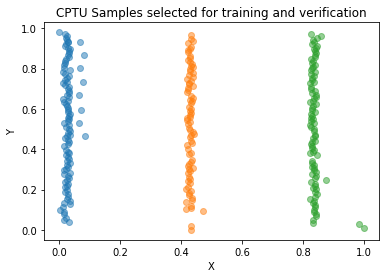

In [ ]:
# Check the locations of the test samples
xcoord_first = df_locations_first['X'].to_numpy()
ycoord_first = df_locations_first['Y'].to_numpy()

xcoord_second = df_locations_second['X'].to_numpy()
ycoord_second = df_locations_second['Y'].to_numpy()

xcoord_third = df_locations_third['X'].to_numpy()
ycoord_third = df_locations_third['Y'].to_numpy()

plt.scatter(xcoord_first, ycoord_first, alpha=0.5)
plt.scatter(xcoord_second, ycoord_second, alpha=0.5)
plt.scatter(xcoord_third, ycoord_third, alpha=0.5)
plt.title('CPTU Samples selected for training and verification')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Assumption

To use CNN, it is assumed that the data points are collected at a constant interval such that the data can be treated as images.

std: 0.005369007842158636 | mean: 0.01031661422858702 | std/mean: 0.520423437689594


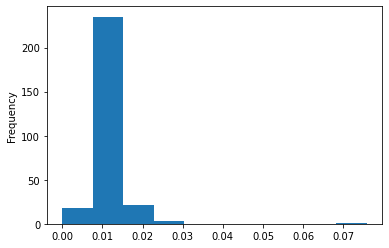

In [ ]:
# Validity of constant interval assumption

# 1. find distances between adjacent data points in Y direction
dist_data_points = pd.concat([df_locations_first['Y'], df_locations_second['Y'], df_locations_third['Y']], axis=0).diff().abs().astype(float)
dist_data_points = dist_data_points[dist_data_points < 0.4]

print('std: {} | mean: {} | std/mean: {}'.format(dist_data_points.std(), dist_data_points.mean(), dist_data_points.std()/dist_data_points.mean()))
dist_data_points.plot.hist()

In [ ]:
dfs_locations = [df_locations_first, df_locations_second, df_locations_third]
sample_colors =  ['blue', 'orange', 'green']

In [ ]:
# Convert dataframe to 40x40 tensors

# 1. consider df_locations_first
labels = df_locations_first['Label']

# 2. create a large ~80x2701 image for tip resistance, friction and pore pressure

dataTypes = ['Tip Resistance (MPa)', 'Friction (MPa)', 'Pore (MPa)']
measurement_data_dict = {}
measurement_data_list_dict = {}
for dataType in dataTypes:
  measurement_data_split_list = []
  measurement_data_list = []

  # only keep line blue and orange
  for df in dfs_locations[:]:
    labels = df['Label']
    measurement_list = []

    for label in labels:
      if not (label in dfs_CPTU_standardized):
        continue

      measurement = torch.tensor(np.array(dfs_CPTU_standardized[label][[dataType]]))
      measurement_list.append(measurement)

    measurement_data = torch.squeeze(torch.stack(measurement_list)).float()
    num_labels = measurement.size()[0]

    measurement_data_list.append(measurement_data)

    measurement_data_split = torch.stack(torch.split(measurement_data, 40, dim=1)[:-1])
    measurement_data_split = torch.cat(torch.split(measurement_data_split, 40, dim=1)[:-1])
    measurement_data_split = torch.unsqueeze(measurement_data_split, 1)

    measurement_data_split_list.append(measurement_data_split)

  measurement_data_combined = torch.cat(measurement_data_split_list)

  measurement_data_dict[dataType] = measurement_data_combined
  measurement_data_list_dict[dataType] = measurement_data_list
  print(measurement_data_combined.shape)

torch.Size([410, 1, 40, 40])
torch.Size([410, 1, 40, 40])
torch.Size([410, 1, 40, 40])


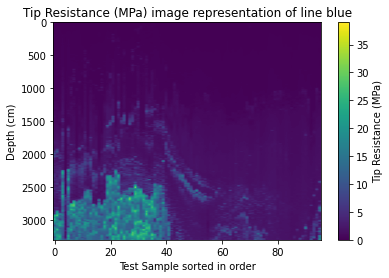

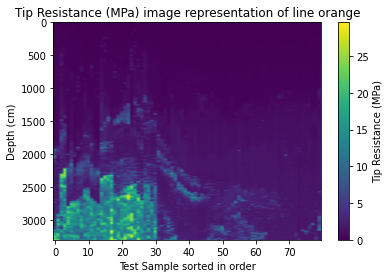

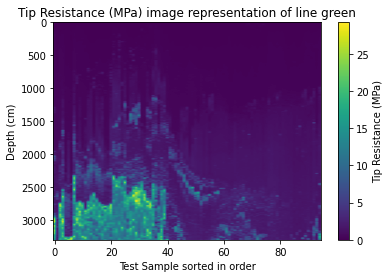

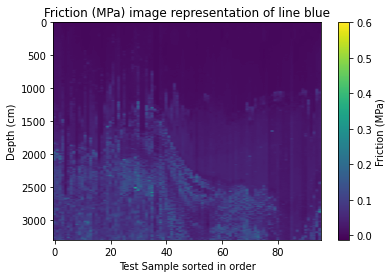

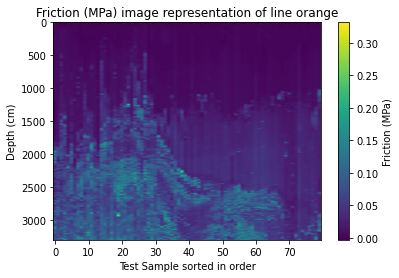

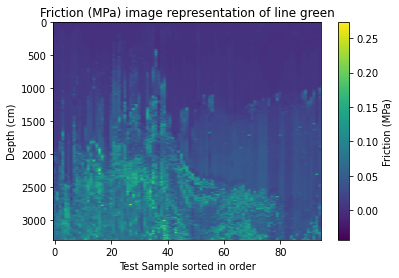

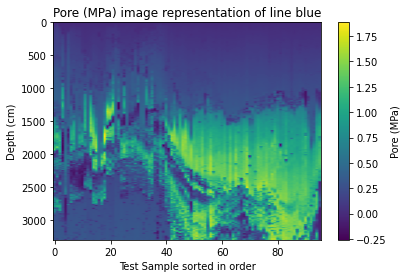

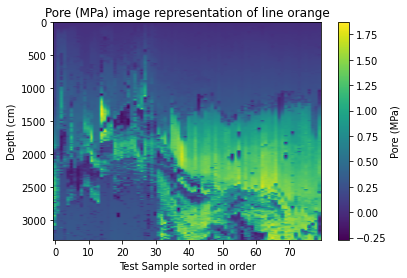

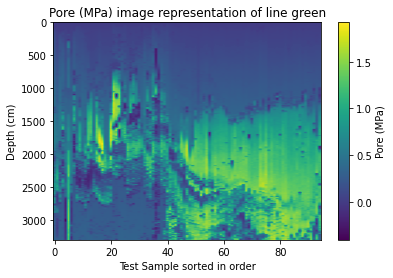

torch.Size([95, 3301])


In [ ]:
for dataType in dataTypes:
  measurement_data_list = measurement_data_list_dict[dataType]
  for data, color in zip(measurement_data_list, sample_colors):
    plt.imshow(data.numpy().T, aspect='auto')
    plt.title('{} image representation of line {}'.format(dataType, color))
    plt.xlabel('Test Sample sorted in order')
    plt.ylabel('Depth (cm)')
    cbar = plt.colorbar()
    cbar.set_label('{}'.format(dataType), rotation=90)

    plt.show()

print(data.size())

## Model

An ensembled model with two Convolutional Autoencoders. Two images are fed in separately, one being the masked image and another being the reconstructed image preprocessed using KNN.

In [ ]:
# Define ensemble layer
class EnsembleLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size, use_cuda=False):
        super().__init__()
        self.size = size
        weights = torch.Tensor(*size)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.

        # initialize weights
        nn.init.kaiming_uniform_(self.weights, a=m.sqrt(5)) # weight init

    def forward(self, x1, x2):
        w_times_x1 = x1 * torch.sigmoid(self.weights)

        ones = torch.ones(*self.size)
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          ones = ones.cuda()
        #############################################

        w_times_x2 = x2 * (ones - torch.sigmoid(self.weights))

        return w_times_x1 + w_times_x2  # 

In [ ]:
# Build autoencoder architecture

class AutoencoderDIP(nn.Module):  
    def __init__(self, size):
        super().__init__()

        self.name = 'AutoencoderDIP'

        ### Convolutional section 1
        self.encoder_cnn_1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=1, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4, 8, 3, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
        )

        self.decoder_conv_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=1, 
            padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
            padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 8, 3, stride=1, 
            padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8, 4, 3, stride=1, 
            padding=2, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(4, 1, 3, stride=1, 
            padding=3, output_padding=0)
        )

        ### Convolutional section 2
        self.encoder_cnn_2 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=1, padding=3),
            # nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4, 8, 3, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
        )

        self.decoder_conv_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=1, 
            padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
            padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 8, 3, stride=1, 
            padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8, 4, 3, stride=1, 
            padding=2, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(4, 1, 3, stride=1, 
            padding=3, output_padding=0)
        )

        self.ensemble = EnsembleLayer(size)
        
    def forward(self, x1, x2=None):
        if x2 is None:
            x1 = self.encoder_cnn_1(x1)
            x1 = self.decoder_conv_1(x1)
            x = torch.sigmoid(x1)

        else:
            x1 = self.encoder_cnn_1(x1)
            x1 = self.decoder_conv_1(x1)
            x1 = torch.sigmoid(x1)

            x2 = self.encoder_cnn_2(x2)
            x2 = self.decoder_conv_2(x2)
            x2 = torch.sigmoid(x2)

            x = self.ensemble(x1,x2)

        return x

## Training

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import math as m
import copy

# Base

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html

# Split data into train, validation and test sets
def get_data_loader(data, batch_size=16, train_ratio=0.7, val_ratio=0.15, random=True):
  np.random.seed(50)

  # shuffle indices
  relevant_indices = list(range(len(data)))

  if random:
    np.random.shuffle(relevant_indices)

  # split
  train_split = int(len(relevant_indices) * train_ratio)
  val_split = train_split + int(len(relevant_indices) * val_ratio)

  relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:train_split], relevant_indices[train_split:val_split], relevant_indices[val_split:]
  
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  if not random:
    train_sampler = None
  train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
  
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                            num_workers=1, sampler=val_sampler)
  
  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                            num_workers=1, sampler=test_sampler)

  return train_loader, val_loader, test_loader

In [ ]:
# implement train function

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion, model_type='CNN', missingRate=0.3, img_shape=(40,40)):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """

    # hardcoded - only test 'sample' missing
    mask_matrix_sample = mask(img_shape, rate=missingRate, missingType='sample')
    mask_matrix_all = mask(img_shape, rate=missingRate, missingType='all')

    for data in loader:
        data_min, data_max = data.min(), data.max()
        normalized_data = (data - data_min)/(data_max - data_min)

        mask_batch = torch.stack([torch.from_numpy(mask_matrix_sample) for _ in range(len(data))]).unsqueeze(1)
        
        data_mask = normalized_data * mask_batch # zero out one categorical feature

        # imputed with KNN ------------------------------
        data_masked_sample = np.ma.array(normalized_data, mask=mask_batch.detach().numpy())
        data_masked_sample_nan = data_masked_sample.filled(np.nan)

        data_imputed_sample_list = []
        for i in range(len(data_masked_sample)):
            imputer = KNNImputer(n_neighbors=3)
            imputed_np = imputer.fit_transform(data_masked_sample_nan[i][0])
            data_imputed = torch.from_numpy(imputed_np)

            data_imputed_sample_list.append(data_imputed)

        data_imputed_sample = torch.stack(data_imputed_sample_list).unsqueeze(1)

        recon = model(data_mask, data_imputed_sample)

        rescaled_recon = recon * (data_max - data_min) + data_min

        loss = criterion(rescaled_recon, data)

    return float(loss)

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.show()

    n = len(train_loss) # number of epochs

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.legend(loc='best')
    plt.show()

###############################################################################
# Metrics
def symmetric_mean_absolute_error(y_true, y_pred, tolerance=0.05):
    threshold = np.amax(y_true)*0.05
    filtered = np.where(y_true >= threshold)
    y_true = y_true[filtered]
    y_pred = y_pred[filtered]
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 0.00001))

In [ ]:
def mask(shape, rate=0.3, missingType='all'):
    ''' Types: all, sample, depth '''

    if missingType == 'all':
        maskMatrix = np.random.choice([True, False], size=shape, p=[rate, 1-rate])

    elif missingType == 'sample':
        maskedRows = np.random.choice(shape[0], size=int(shape[0]*rate), replace=False)
        maskMatrix = np.zeros(shape, dtype=bool)
        maskMatrix[maskedRows, :] = True

    elif missingType == 'depth':
        maskedCols = np.random.choice(shape[1], size=int(shape[1]*rate), replace=False)
        maskMatrix = np.zeros(shape, dtype=bool)
        maskMatrix[:, maskedCols] = True

    return maskMatrix

def train(model, train_loader, val_loader, batch_size=16, num_epochs=5, learning_rate=1e-4, ensemble=True, missingRate=0.3, img_shape=(40,40)):
    """ Training loop. You should update this."""
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    outputs = []

    mask_matrix_sample = mask(img_shape, rate=missingRate, missingType='sample')
    mask_matrix_all = mask(img_shape, rate=missingRate, missingType='all')

    for epoch in range(num_epochs):
        for img in train_loader:
            img_min, img_max = img.min(), img.max()
            normalized_img = (img - img_min)/(img_max - img_min)

            mask_sample_batch = torch.stack([torch.from_numpy(mask_matrix_sample) for _ in range(len(img))]).unsqueeze(1)
            mask_all_batch = torch.stack([torch.from_numpy(mask_matrix_all) for _ in range(len(img))]).unsqueeze(1)

            # filled with zeros ------------------------------
            img_zeros_sample = normalized_img * mask_sample_batch # zero out
            img_zeros_all = normalized_img * mask_all_batch # zero out

            # imputed with KNN ------------------------------
            img_masked_sample = np.ma.array(normalized_img, mask=mask_sample_batch.detach().numpy())
            img_masked_sample_nan = img_masked_sample.filled(np.nan)

            img_masked_all = np.ma.array(normalized_img, mask=mask_all_batch.detach().numpy())
            img_masked_all_nan = img_masked_all.filled(np.nan)

            image_imputed_sample_list = []
            image_imputed_all_list = []
            for i in range(len(img_masked_sample)):
                imputer = KNNImputer(n_neighbors=3)
                imputed_np = imputer.fit_transform(img_masked_sample_nan[i][0])
                img_imputed = torch.from_numpy(imputed_np)

                image_imputed_sample_list.append(img_imputed)

                imputer = KNNImputer(n_neighbors=3)
                imputed_np = imputer.fit_transform(img_masked_all_nan[i][0])
                img_imputed = torch.from_numpy(imputed_np)

                image_imputed_all_list.append(img_imputed)

            image_imputed_sample = torch.stack(image_imputed_sample_list).unsqueeze(1)
            image_imputed_all = torch.stack(image_imputed_all_list).unsqueeze(1)

            # plt.imshow(img_masked.filled(0).T, aspect='auto')
            # plt.show()
            # plt.imshow(imputed_np.T, aspect='auto')
            # plt.show()

            # recon = model(img_mask, img_imputed_KNN)
            recon = model(img_zeros_sample, image_imputed_sample)

            # rescaled_recon = recon * (img_max - img_min) + img_min

            # loss = criterion(rescaled_recon, img) # okay thats straightforward

            loss = criterion(recon, normalized_img)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss[epoch] = float(loss)
        val_loss[epoch] = evaluate(model, val_loader, criterion, missingRate=missingRate)

        print(("Epoch {}: Train loss: {} | Validation loss: {}").format(
                   epoch + 1,
                   train_loss[epoch],
                   val_loss[epoch]))
    
    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
    torch.save(model.state_dict(), model_path)

    print('Finished Training')
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [ ]:
data_loaders = {}
for dataType in dataTypes:
  data_loaders[dataType] = get_data_loader(measurement_data_dict[dataType], batch_size=16)

  train_loader, val_loader, test_loader = data_loaders[dataType]
  print('Data type:', dataType)
  print('Number of batches in training set:', len(train_loader))
  print('Number of batches in validation set:', len(val_loader))
  print('Number of batches in test set:', len(test_loader))

Data type: Tip Resistance (MPa)
Number of batches in training set: 18
Number of batches in validation set: 4
Number of batches in test set: 4
Data type: Friction (MPa)
Number of batches in training set: 18
Number of batches in validation set: 4
Number of batches in test set: 4
Data type: Pore (MPa)
Number of batches in training set: 18
Number of batches in validation set: 4
Number of batches in test set: 4


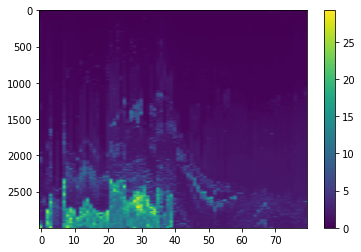

In [ ]:
# Select test image
# Choice: line green tip resistance

image = measurement_data_list_dict[dataTypes[0]][2].numpy()[:80, :3000]
plt.imshow(image.T, aspect='auto')
plt.colorbar()

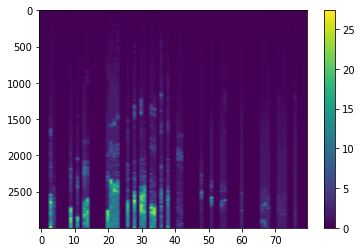

In [ ]:
# Data/image masking

def sample_image(image, rate=0.5):
    mask_matrix = mask(image.shape, rate=rate, missingType='sample')
    image_masked = np.ma.array(image, mask=mask_matrix)
    image_masked_nan = image_masked.filled(np.nan)
    image_masked_zero = image_masked.filled(0)

    indices_masked = np.where(mask_matrix.T[0] == True)[0]

    return mask_matrix, image_masked, image_masked_nan, image_masked_zero, indices_masked

mask_matrix, image_masked, image_masked_nan, image_masked_zero, indices_masked = sample_image(image, rate=0.6)

plt.imshow(image_masked_zero.T, aspect='auto')
plt.colorbar()

## Baseline Models
1. KNN Imputation
2. Linear & Bicubic Interpolation

In [ ]:
# Baseline models
# 1. K-NN imputation

def kNN_imputation(image_masked_nan, image, indices_masked, n_neighbors=1):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    image_imputed_KNN = imputer.fit_transform(image_masked_nan)
    
    # Error calculation
    rmse = mean_squared_error(image[indices_masked], image_imputed_KNN[indices_masked], squared=False)
    mape = symmetric_mean_absolute_error(image[indices_masked], image_imputed_KNN[indices_masked])

    # plt.imshow(image_imputed_KNN.T, aspect='auto')
    # plt.colorbar()

    return image_imputed_KNN, rmse, mape

image_imputed_KNN, KNN_rmse, KNN_mape = kNN_imputation(image_masked_nan, image, indices_masked, n_neighbors=1)

print('RMSE:', KNN_rmse)

# plt.imshow(image_imputed_KNN.T, aspect='auto')
# plt.colorbar()

RMSE: 1.9770063


In [ ]:
# Baseline models
# 2. Neareast, linear and bicubic interpolation

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from skgstat import OrdinaryKriging
from skgstat import Variogram

def nearest_linear_bicubic_kriging_interpolation(image_masked, image, indices_masked, mask_matrix):
    dim_x, dim_y = image_masked.shape
    grid_x, grid_y = np.mgrid[0:int(dim_x), 0:int(dim_y)]

    # find points that arent masked
    points = []
    for i in range(len(mask_matrix)):
        for j in range(len(mask_matrix[0])):
            if mask_matrix[i][j] == False:
                points.append([i,j])
    points = np.array(points)

    # find their respective values
    values = []
    for x, y in points:
        values.append(image_masked[x][y])

    values = np.array(values)

    nearest_out = np.nan_to_num(griddata(points, values, (grid_x, grid_y), method='nearest'), 0)
    nearest_loss = mean_squared_error(image[indices_masked], nearest_out[indices_masked], squared=False)
    nearest_mape = symmetric_mean_absolute_error(image[indices_masked], nearest_out[indices_masked])

    linear_out = np.nan_to_num(griddata(points, values, (grid_x, grid_y), method='linear'), 0)
    linear_loss = mean_squared_error(image[indices_masked], linear_out[indices_masked], squared=False)
    linear_mape = symmetric_mean_absolute_error(image[indices_masked], linear_out[indices_masked])

    cubic_out = np.nan_to_num(griddata(points, values, (grid_x, grid_y), method='cubic'), 0)
    cubic_loss = mean_squared_error(image[indices_masked], cubic_out[indices_masked], squared=False)
    cubic_mape = symmetric_mean_absolute_error(image[indices_masked], cubic_out[indices_masked])

    return (nearest_out, nearest_loss, nearest_mape), (linear_out, linear_loss, linear_mape), (cubic_out, cubic_loss, cubic_mape)

# (grid_z0, nearest_loss), (grid_z1, linear_loss), (grid_z2, cubic_loss) = nearest_linear_bicubic_interpolation(image_masked, mask_matrix)

# plt.subplot(221)
# plt.imshow(grid_z0.T, origin='upper', aspect='auto')
# plt.title('Nearest | MSE: {}'.format(nearest_loss.round(1)))
# plt.subplot(222)
# plt.imshow(grid_z1.T, origin='upper', aspect='auto')
# plt.title('Linear | MSE: {}'.format(round(linear_loss, 3)))
# plt.subplot(223)
# plt.imshow(grid_z2.T, origin='upper', aspect='auto')
# plt.title('Cubic | MSE: {}'.format(round(cubic_loss, 3)))
# # set the spacing between subplots
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)
# plt.show()

In [ ]:
import numpy as np
def train_regressors(regressor, image, mask_matrix, indices_masked):
    height, width = image.shape
    flat_image = image.reshape(-1)

    xs = np.arange(len(flat_image)) % width
    ys = np.arange(len(flat_image)) // width 

    data = np.array([xs,ys]).T

    # find points that arent masked
    # points.shape = (number of samples, number of features)
    points = []
    train_y = []
    k = 0
    for i in range(len(mask_matrix)):
        for j in range(len(mask_matrix[0])):
            if mask_matrix[i][j] == False:
                points.append([i,j])
                train_y.append(flat_image[k])
            k += 1

    train_x = np.array(points)
    train_y = np.array(train_y)

    mean = train_y.mean()
    regressor.fit(train_x, train_y - mean)
    reconstructed_flat = regressor.predict(data) + mean

    # reshape reconstructed3
    reconstructed = reconstructed_flat.reshape(height, width)

    # Get RMSE and MAPE
    rmse = mean_squared_error(image[indices_masked], reconstructed[indices_masked], squared=False)
    mape = symmetric_mean_absolute_error(image[indices_masked], reconstructed[indices_masked])

    return rmse, mape
    

In [ ]:
def single_point_visualization(real, recons, labels, selected_index, title, path):
    for recon, label in zip(recons, labels):
        sample_real = real.squeeze()
        sample_real = sample_real[selected_index,:]

        sample_recon = recon
        sample_recon = recon[selected_index,:]

        
        plt.plot(sample_real, [i for i in range(len(sample_real))], label="real")	#plot the points
        plt.plot(sample_recon, [i for i in range(len(sample_real))], label=label)	#plot the points
        plt.title(title)
        plt.legend()
        plt.gca().invert_yaxis()
        plt.savefig('{}{}-{}.png'.format(path, title, label))
        plt.show()
        

**Deep Image Prior Concept!

In [ ]:
def train_DIP(model, img, img_imputed, mask, batch_size=16, num_epochs=5, learning_rate=1e-4, use_cuda=False):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    torch.manual_seed(30)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    outputs = []

    mask = torch.from_numpy(mask).int()
    img = torch.from_numpy(img)

    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        mask = mask.cuda()
        img = img.cuda()
    #############################################

    # normalizing images
    img_min, img_max = img.min(), img.max()
    normalized_img = (img - img_min)/(img_max - img_min)
    img_masked = (normalized_img * mask).float().unsqueeze(0).unsqueeze(0)

    # normalize the imputed image
    if img_imputed is not None:
        img_imputed = torch.from_numpy(img_imputed)

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            img_imputed = img_imputed.cuda()
        #############################################

        img_imputed_min, img_imputed_max = img_imputed.min(), img_imputed.max()
        normalized_img_imputed = (img_imputed - img_imputed_min)/(img_imputed_max - img_imputed_min)
        img_imputed_new = normalized_img_imputed.unsqueeze(0).unsqueeze(0)

    for epoch in range(num_epochs):
        if img_imputed is not None:
            recon = model(img_masked, img_imputed_new)
        else:
            recon = model(img_masked)

        recon_masked = (recon * mask).float()

        loss = criterion(recon_masked, img_masked) # okay thats straightforward
        # loss.requires_grad = True

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        actual_loss = criterion(recon, normalized_img)

        train_loss[epoch] = float(actual_loss)

        print(("Epoch {}: Train loss: {}").format(
                   epoch + 1,
                   train_loss[epoch]))
    
    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
    torch.save(model.state_dict(), model_path)

    print('Finished Training')
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

## Model Performance

The final model uses the concept of Deep Image Prior (DIP) and Convolutional Autoencoder, which outperforms all the baseline models.

In [ ]:
# Try different data type, missing rates & num of samples
timestamp = str(datetime.now())
img_path = '/content/drive/MyDrive/UofT Civil Engineering/2022 Summer/Summer Research at SUSTech/results/image_{}/'.format(timestamp)
os.mkdir(img_path)

DATA_TYPES = ['Tip Resistance (MPa)', 'Friction (MPa)', 'Pore (MPa)']
MISSING_RATES = [i*0.1 for i in range(2,8)]
NUM_SAMPLES = 15
metrics = {
    'dataType': [],
    'method':[],
    'rate': [],
    'loss': [],
    'MAPE': [],
}

use_cuda = True

for i, dataType in enumerate(DATA_TYPES):
    image_selected = measurement_data_list_dict[dataType][0].numpy()[:80, :3000]
    print(image_selected.shape)
    for rate in MISSING_RATES:
        for i in range(NUM_SAMPLES):
            # sample test images
            mask_matrix, image_masked, image_masked_nan, image_masked_zero, indices_masked = sample_image(image_selected, rate=rate)
            # Baseline method
            image_imputed_KNN, KNN_rmse, KNN_mape = kNN_imputation(image_masked_nan, image_selected, indices_masked, n_neighbors=2)
            metrics['dataType'].append(dataType)
            metrics['method'].append('KNN')
            metrics['rate'].append(float(rate))
            metrics['loss'].append(float(KNN_rmse))
            metrics['MAPE'].append(float(KNN_mape))

            (nearest_out, nearest_loss, nearest_mape), (linear_out, linear_loss, linear_mape), (cubic_out, cubic_loss, cubic_mape) = nearest_linear_bicubic_kriging_interpolation(image_masked, image, indices_masked, mask_matrix)
            metrics['dataType'].append(dataType)
            metrics['method'].append('nearest')
            metrics['rate'].append(float(rate))
            metrics['loss'].append(float(nearest_loss))
            metrics['MAPE'].append(float(nearest_mape))

            metrics['dataType'].append(dataType)
            metrics['method'].append('linear')
            metrics['rate'].append(float(rate))
            metrics['loss'].append(float(linear_loss))
            metrics['MAPE'].append(float(linear_mape))

            metrics['dataType'].append(dataType)
            metrics['method'].append('cubic')
            metrics['rate'].append(float(rate))
            metrics['loss'].append(float(cubic_loss))
            metrics['MAPE'].append(float(cubic_mape))

            regressors = {
                'svr': LinearSVR(random_state=0, tol=1e-05),
                'random_forest': RandomForestRegressor(n_estimators=100),
            }

            for reg_name in regressors:
                loss, mape = train_regressors(regressors[reg_name], image_selected, mask_matrix, indices_masked)
                metrics['dataType'].append(dataType)
                metrics['method'].append(reg_name)
                metrics['rate'].append(float(rate))
                metrics['loss'].append(float(loss))
                metrics['MAPE'].append(float(mape))

            # metrics['dataType'].append(dataType)
            # metrics['method'].append('kriging')
            # metrics['rate'].append(float(rate))
            # metrics['loss'].append(float(kriging_loss))
            # metrics['MAPE'].append(float(kriging_mape))

            # DIP method --------------------------------------------
            model = AutoencoderDIP(image_selected.shape)
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              model = model.cuda()
            #############################################
            train_DIP(model, image_selected, image_imputed_KNN, mask_matrix, batch_size=16, num_epochs=600, learning_rate=3e-4, use_cuda=use_cuda)

            img_min, img_max = image_selected.min(), image_selected.max()
            normalized_img = (image_selected - img_min)/(img_max - img_min)
            normalized_img = torch.from_numpy(normalized_img)
            img_masked = (normalized_img * mask_matrix).float().unsqueeze(0).unsqueeze(0)

            img_imputed_min, img_imputed_max = image_imputed_KNN.min(), image_imputed_KNN.max()
            normalized_img_imputed = (image_imputed_KNN - img_imputed_min)/(img_imputed_max - img_imputed_min)
            normalized_img_imputed = torch.from_numpy(normalized_img_imputed)
            img_imputed_new = normalized_img_imputed.unsqueeze(0).unsqueeze(0)

            image_torch = torch.from_numpy(image_selected)

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                img_masked = img_masked.cuda()
                img_imputed_new = img_imputed_new.cuda()
                image_torch = image_torch.cuda()
            #############################################

            recon = model(img_masked, img_imputed_new)

            recon_original_scale = recon * (img_max - img_min) + img_min
            recon_original_scale_np = recon_original_scale.cpu().squeeze().detach().numpy()

            criterion = nn.MSELoss()
            recon_loss = criterion(recon_original_scale.squeeze(), image_torch)
            recon_mape = symmetric_mean_absolute_error(recon_original_scale_np,image_selected)
            # recon_loss = criterion(recon_original_scale.squeeze()[indices_masked], image_torch[indices_masked])
            # recon_mape = symmetric_mean_absolute_error(recon_original_scale_np[indices_masked],image_selected[indices_masked])

            # Single point visualization
            selected_index = indices_masked[random.randint(0, len(indices_masked)-1)]

            recon_DIP = recon_original_scale.cpu().squeeze(0).squeeze(0).detach().numpy()
            title = 'Reconstruction Comparision | Missing Rate: {} | Data Type: {}'.format(round(rate,1), dataType)
            single_point_visualization(image_selected, [recon_DIP, linear_out], ['DIP', 'linear'], selected_index, title, img_path)

            plt.imshow(recon_original_scale_np.T, aspect='auto')
            plt.colorbar()
            plt.savefig(img_path + title + '.png')
            plt.show()

            metrics['dataType'].append(dataType)
            metrics['method'].append('DIP')
            metrics['rate'].append(float(rate))
            metrics['loss'].append(float(recon_loss))
            metrics['MAPE'].append(float(recon_mape))

df_metrics = pd.DataFrame(metrics)

In [ ]:
filepath = '/content/drive/MyDrive/UofT Civil Engineering/2022 Summer/Summer Research at SUSTech/results/'
timestamp = str(datetime.now())

df_metrics.to_csv('{}_result_{}.csv'.format(filepath, timestamp))
df_metrics

### Results

The two performance evaluation metric are root mean square error (RMSE) and mean absolute percentage error (MAPE).


                                           loss       MAPE
dataType             rate method                          
Friction (MPa)       0.2  DIP      6.839480e-10  13.927790
                          KNN      1.673098e-06  11.795972
                          cubic    1.182565e-01   0.564087
                          linear   1.183511e-01   0.558878
                          nearest  1.184054e-01   0.423714
...                                         ...        ...
Tip Resistance (MPa) 0.7  DIP      8.283034e-04   1.012304
                          KNN      6.351231e-03   2.647450
                          cubic    1.958269e-01  86.751044
                          linear   1.432841e-02  83.425558
                          nearest  1.918164e-02   8.529185

[90 rows x 2 columns]


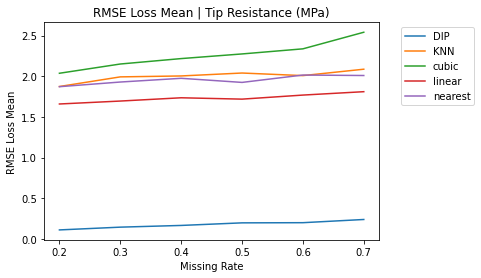

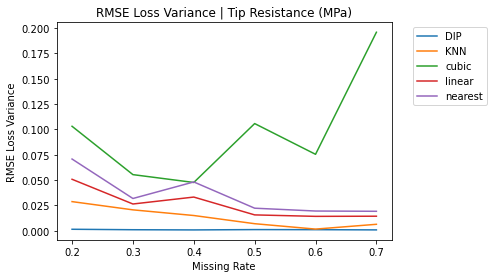

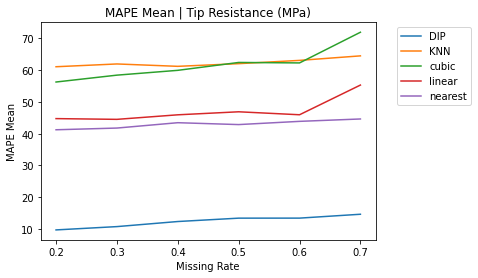

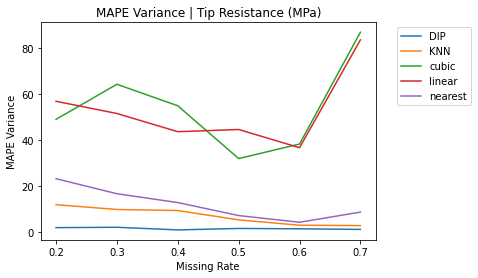

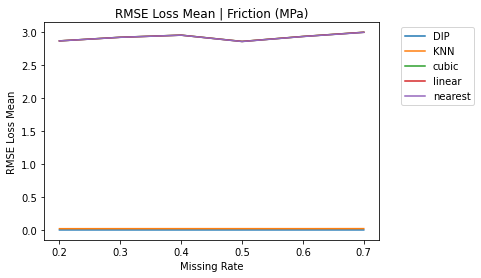

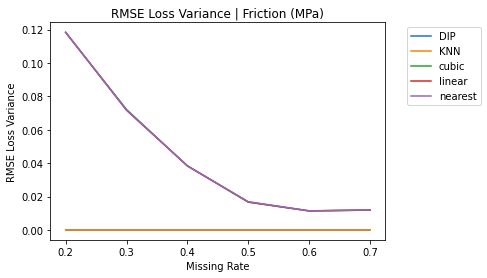

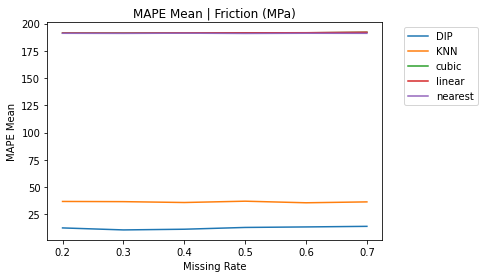

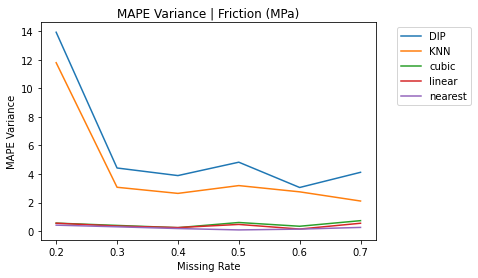

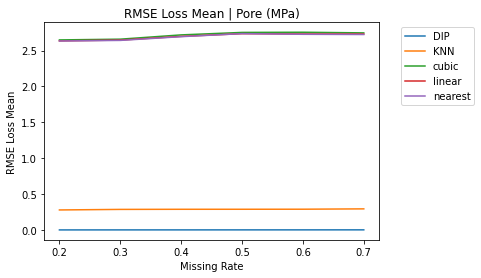

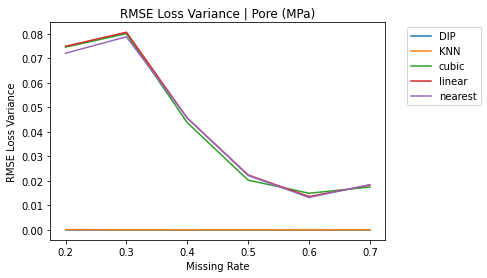

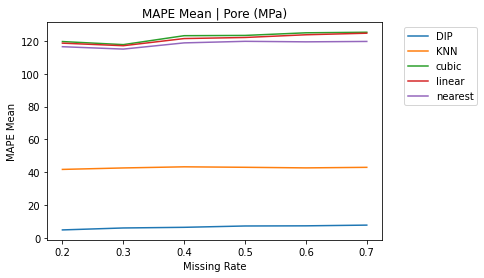

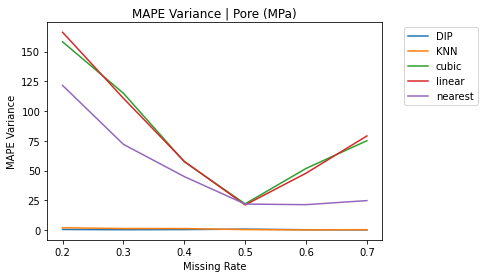

In [ ]:
# load data
import scipy.stats as st

NUM_SAMPLES = 15
filepath = '/content/drive/MyDrive/UofT Civil Engineering/2022 Summer/Summer Research at SUSTech/results/'
onlyfiles = [f for f in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, f))]

filepath = '/content/drive/MyDrive/UofT Civil Engineering/2022 Summer/Summer Research at SUSTech/results/_result_2022-10-13 08:25:52.642918.csv'
df_data = pd.read_csv(filepath)

df_data_mean = df_data.groupby(['dataType', 'rate', 'method'])['loss', 'MAPE'].mean()
df_data_var = df_data.groupby(['dataType', 'rate', 'method'])['loss', 'MAPE'].var()
df_data_std = df_data.groupby(['dataType', 'rate', 'method'])['loss', 'MAPE'].std()

print(df_data_var)

CONFIDENCE = 0.99
Z_value = st.norm.ppf(CONFIDENCE)
df_data_confidence_interval = df_data_mean + df_data_std * Z_value / m.sqrt(NUM_SAMPLES)

DATA_TYPES = ['Tip Resistance (MPa)', 'Friction (MPa)', 'Pore (MPa)']

# plot
for dtype in DATA_TYPES:
    sns.lineplot(data=df_data_mean.loc[dtype], x="rate", y="loss", hue="method", ci=None)
    plt.title('RMSE Loss Mean | {}'.format(dtype))
    plt.xlabel('Missing Rate')
    plt.ylabel('RMSE Loss Mean')
    plt.legend(bbox_to_anchor= (1.3,1))
    plt.show()

    sns.lineplot(data=df_data_var.loc[dtype], x="rate", y="loss", hue="method", ci=None)
    plt.title('RMSE Loss Variance | {}'.format(dtype))
    plt.xlabel('Missing Rate')
    plt.ylabel('RMSE Loss Variance')
    plt.legend(bbox_to_anchor= (1.3,1))
    plt.show()

    sns.lineplot(data=df_data_mean.loc[dtype], x="rate", y="MAPE", hue="method", ci=None)
    plt.title('MAPE Mean | {}'.format(dtype))
    plt.xlabel('Missing Rate')
    plt.ylabel('MAPE Mean')
    plt.legend(bbox_to_anchor= (1.3,1))
    plt.show()

    sns.lineplot(data=df_data_var.loc[dtype], x="rate", y="MAPE", hue="method", ci=None)
    plt.title('MAPE Variance | {}'.format(dtype))
    plt.xlabel('Missing Rate')
    plt.ylabel('MAPE Variance')
    plt.legend(bbox_to_anchor= (1.3,1))
    plt.show()
